<a href="https://colab.research.google.com/github/Rajaa252/BigData/blob/main/Sesi%C3%B3n_2_Regularizaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regularización

En este notebook se revisarán los conceptos de:

1. Regularización en regresión
    1. Ridge regression
    2. LASSO
2. Regularización en clasificación
    1. Regresión logística

## 0. Configuración del entorno de trabajo

In [ ]:
# clonar el resto del repositorio si no está disponible
import os
curr_dir = os.getcwd()
if not os.path.exists(os.path.join(curr_dir, '../.ROOT_DIR')):
    !git clone https://github.com/masdeseiscaracteres/ml_course.git ml_course
    os.chdir(os.path.join(curr_dir, 'ml_course/material'))

Cloning into 'ml_course'...
remote: Enumerating objects: 243, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 243 (delta 14), reused 3 (delta 3), pack-reused 212
Receiving objects: 100% (243/243), 12.89 MiB | 13.25 MiB/s, done.
Resolving deltas: 100% (123/123), done.


Primero cargamos las bibliotecas y definimos unas funciones auxiliares que utilizaremos más adelante:

In [ ]:
import numpy as np
import pandas as pd
from numpy.linalg import norm

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# definimos una función para representar el resultado del ajuste
def plot_decision_boundary(X, y, h, model):

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = .05  # step size in the mesh

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Zd = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Zd = Zd.reshape(xx.shape)

    Zp = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    Zp = Zp.reshape(xx.shape)

    # Error de clasificación
    ypred = model.predict(X)
    acc = accuracy_score(y,ypred)

    plt.figure(1, figsize=(12, 5))

    plt.subplot(1,2,1)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.axis([x_min, x_max, y_min, y_max])
    plt.contour(xx, yy, Zd, levels=[0], linewidths=2)
    plt.contourf(xx, yy, Zd, cmap=cm, alpha=.5)
    plt.xlabel("$x_1$", fontsize=16)
    plt.ylabel("$x_2$", fontsize=16)
    msg = 'FRONTERA DECISION\n Acc: %0.2g' % acc
    plt.title(msg)

    plt.subplot(1,2,2)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.axis([x_min, x_max, y_min, y_max])
    #plt.contour(xx, yy, Zp, levels=[0], linewidths=2)
    plt.contourf(xx, yy, Zp, cmap=cm, alpha=.5)
    plt.xlabel("$x_1$", fontsize=16)
    plt.ylabel("$x_2$", fontsize=16)
    msg = 'PROBABILIDAD\n Acc: %0.2g' % acc
    plt.title(msg)

    plt.tight_layout()
    plt.show()

In [ ]:
# definimos una función para representar el resultado del ajuste
def plot_decision_boundary_poly(X,y,h,model,poly):

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = .05  # step size in the mesh

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    XX = np.c_[xx.ravel(), yy.ravel()]
    Zd = model.predict(poly.fit_transform(XX))
    Zd = Zd.reshape(xx.shape)

    Zp = model.predict_proba(poly.fit_transform(XX))[:,1]
    Zp = Zp.reshape(xx.shape)

    # Error de clasificación
    ypred = model.predict(poly.fit_transform(X))
    acc = accuracy_score(y,ypred)

    plt.figure(1, figsize=(12, 5))

    plt.subplot(1,2,1)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.axis([x_min, x_max, y_min, y_max])
    plt.contour(xx, yy, Zd, levels=[0], linewidths=2)
    plt.contourf(xx, yy, Zd, cmap=cm, alpha=.5)
    plt.xlabel("$x_1$", fontsize=16)
    plt.ylabel("$x_2$", fontsize=16)
    msg = 'FRONTERA DECISION\n Acc: %0.2g' % acc
    plt.title(msg)

    plt.subplot(1,2,2)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.axis([x_min, x_max, y_min, y_max])
    plt.contour(xx, yy, Zp, levels=[0], linewidths=2)
    plt.contourf(xx, yy, Zp, cmap=cm, alpha=.5)
    plt.xlabel("$x_1$", fontsize=16)
    plt.ylabel("$x_2$", fontsize=16)
    msg = 'PROBABILIDAD\n Acc: %0.2g' % acc
    plt.title(msg)

    plt.tight_layout()
    plt.show()

## 1. Regularización sobre algoritmos de regresión

Vamos a trabajar sobre un ejemplo sintético para entender el concepto de regularización.

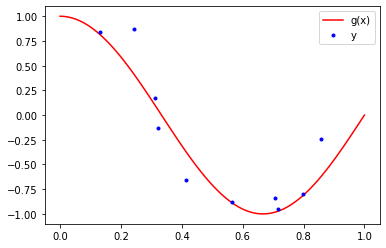

In [ ]:
N_train = 10
N_test  = 100

# función verdadera g(x)
x = np.linspace(0, 1, N_test)
g_x = np.cos(1.5*np.pi*x)

# proceso y
np.random.seed(0) # fijamos la semilla del generador de números aleatorios para asegurar reproducibilidad
epsilon = np.random.randn(N_test) * 0.2
y = g_x + epsilon

# Datos: D = {x_i,y_i}, obtenemos una muestra
idx = np.random.randint(0, N_test, N_train)
x_i = x[idx]
y_i = y[idx]

# dibujamos la función g(x), y el conjunto de datos x_i,y_i
plt.plot(x, g_x, 'r', label='g(x)')
plt.plot(x_i, y_i, 'b.', label='y')
plt.legend()
plt.show()

En primer lugar, ajustamos un modelo (regresión lineal) muy complejo sobre estos datos, de la forma:

$$f_{\omega}(x) = \omega_0 + \sum_{j=1}^{10}\omega_j x^j$$

Decimos que el modelo es complejo porque se trata de un polinomio de grado 10.  Los parámetros del modelo, son los 11 coeficientes ($\omega_0,\ldots,\omega_{10}$). Dada su complejidad este modelo seguramente sufrirá de overfitting.

### Ejercicio
Entrena un algoritmo de regresión lineal y calcula el error cuadrático medio (MSE),
 $$MSE = \frac{1}{N}\sum_{i=1}^N \left(y^{(i)}-\hat{y}^{(i)}\right)^2,$$
del conjunto de test.

### Solución

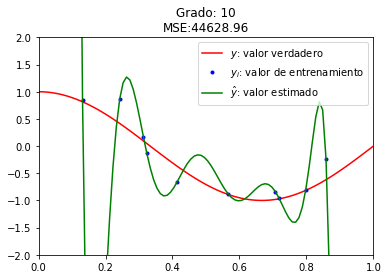

w0:  1018.7297946920598
w1:  -24032.863790231913
w2:  231294.00580164033
w3:  -1191201.141084322
w4:  3568841.934575503
w5:  -6150955.326195235
w6:  5013085.557822482
w7:  1032053.2821085005
w8:  -5939085.949715572
w9:  4781062.586611151
w10:  -1323005.1912186171

||w||_2^2 = 1.4e+14


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

degree = 10

# features
poly    = PolynomialFeatures(degree, include_bias=False) # generamos x^j pero no incluimos el término x^0=1
X_train = poly.fit_transform(x_i[:, None])
y_train = y_i

X_test = poly.fit_transform(x[:, None])
y_test = y

# entrenamiento del modelo
# Nota: nos aseguramos de que el algoritmo ajusta el intercepto con fit_intercept=True (opción po defecto)
# porque anteriormente no hemos añadido el término correspondiente al grado 0
lr = LinearRegression(fit_intercept=True).fit(X_train, y_train)
###

# predicción
y_hat = lr.predict(X_test)

# cálculo del MSE sobre el conjunto de test
mse = np.mean((y-y_hat)**2)
# también podríamos utilizar la función incluida en scikit-learn
# from sklearn.metrics import mean_squared_error
# mse = mean_squared_error(y, y_hat)

# Dibujamos los resultados
plt.plot(x, g_x, 'r', label='$y$: valor verdadero')
plt.plot(x_i, y_i, 'b.', label='$y_i$: valor de entrenamiento')
plt.plot(x, y_hat, 'g', label='$\hat{y}$: valor estimado')
plt.title('Grado: %i\nMSE:%.2f'%(degree, mse))
plt.legend()
plt.xlim((0, 1))
plt.ylim((-2, 2))
plt.show()

# mostramos los coeficientes del modelo
print('w0: ', lr.intercept_)

w = lr.coef_
norm_w2 = np.dot(w, w.T) # no se tiene en cuenta el intercepto

coef_names = ['w' + str(i) + ': ' for i in range(1, degree+1)]
for f, wi in zip(coef_names, w):
    print(f, wi)

print('\n||w||_2^2 = %.2g' % norm_w2)

La gráfica anterior muestra que el modelo es tan expresivo que puede ajustarse perfectamente a los valores de entrenamiento. Sin embargo, no generaliza lo suficientemente bien, y el ajuste para los valores de test no es satisfactorio. Esta situación es lo que se conoce como sobreajuste y los coeficientes altos son una indicación de ello.

### 1.1. Ridge regression

Se refiere al modelo de regresión lineal con penalización sobre la suma cuadrática de los coeficientes:

$$\min_{\boldsymbol{\omega}}|| \mathbf{y} - \mathbf{X}\boldsymbol{\omega}||_2^2 + \alpha ||\boldsymbol{\omega} ||_2^2$$

como medida contra el [*overfitting*](https://en.wikipedia.org/wiki/Overfitting).

El modelo de [*ridge regression*](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html), tiene un hiperparámetro ($\alpha$) que hemos de fijar a priori (no se estima durante la fase de entrenamiento). En otras palabras, tenemos que dar un valor a $\alpha$ para que el modelo calcule los coeficientes (parámetros) $\boldsymbol{\omega}$. A tener en cuenta:

* Si $\alpha = 0$, entonces el resultado coincide con un modelo de [regresión lineal](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).
* Si $\alpha \to \infty$, entonces el valor de todos los coeficientes será nulo.

Por tanto, para buscar el valor de $\alpha$ adecuado, tendremos que barrer valores en una escala que cubra valores muy pequeños y valores elevados. Para ello, normalmente se utiliza escala logarítmica aumentando progresivamente el orden  de magnitud. Como ejemplo, podríamos barrer $\alpha$ utilizando los siguientes valores $\alpha = \{10^{-3},0.01,0.1,1,10,100,1000\}$, que en escala logarítmica queda como $\log_{10}({\alpha}) = \{-3,-2,-1,0,1,2,3\}$

Vamos a aplicar el algoritmo de *ridge regression* variando los valores de $\alpha$, y viendo cómo esta variación afecta a los coeficientes $\boldsymbol{\omega}$ del modelo.

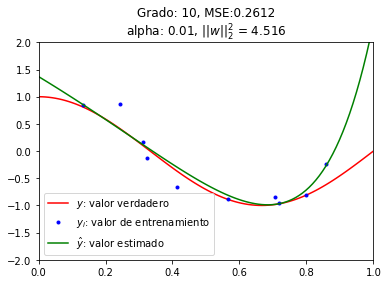

w1:  -3.728372380787362
w2:  -1.221987117667866
w3:  0.46645449633229946
w4:  1.0736041534191907
w5:  1.1274575096542994
w6:  0.9794301415431301
w7:  0.7910882654063865
w8:  0.6220138737395406
w9:  0.48727486628440886
w10:  0.38530050470970423


In [ ]:
from sklearn.linear_model import Ridge

# ajuste del modelo
alpha = 1e-2
ridge = Ridge(alpha=alpha).fit(X_train, y_train)
w = ridge.coef_
norm_w2 = norm(w, 2)

# predicción
y_hat = ridge.predict(X_test)

# error
error_test = np.mean(np.power(y - y_hat, 2))

plt.plot(x, g_x, 'r', label='$y$: valor verdadero')
plt.plot(x_i, y_i, 'b.', label='$y_i$: valor de entrenamiento')
plt.plot(x, y_hat, 'g', label='$\hat{y}$: valor estimado')
plt.title('Grado: {:d}, MSE:{:.4g}\nalpha: {:2g}, $||w||_2^2$ = {:.4g}'.format(degree, error_test, alpha, norm_w2))
plt.legend()
plt.xlim((0, 1))
plt.ylim((-2, 2))
plt.show()

coef_names = ['w' + str(i) + ': ' for i in range(1, degree+1)]

for f, wi in zip(coef_names, w):
    print(f, wi)

### Ejercicio
Varía los valores de $\alpha$ y comprueba cómo afecta al resultado, ¿cómo varían los coeficientes del modelo?

### Solución

Representamos ahora el valor de los coeficientes del modelo y su norma para distintos valores del parámetro de regularización

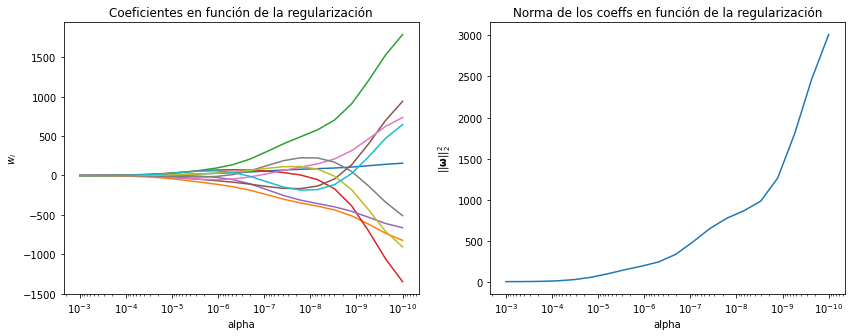

In [ ]:
n_alphas = 20
alphas = np.logspace(-10, -3, n_alphas)

coefs = []

norm2_coefs = []
for a in alphas:
    ridge = Ridge(alpha=a).fit(X_train,y_train)
    coefs.append(ridge.coef_)
    norm2_coefs.append(norm(ridge.coef_,2))

# Display results
plt.figure(figsize=(14, 5))

ax = plt.subplot(1, 2, 1)
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('$w_i$')
plt.title('Coeficientes en función de la regularización')
plt.axis('tight')


ax = plt.subplot(1, 2, 2)
ax.plot(alphas, norm2_coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('$||\mathbf{\omega}||^2_2$')
plt.title('Norma de los coeffs en función de la regularización')
plt.axis('tight')
plt.show()


### Ejercicio
¿Cuál es el valor óptimo de $\alpha$?

### Solución
Para responder a este ejercicio de forma correcta debemos probar con distintos valores de $\alpha$ a partir de los datos, pero ¿cómo calculamos este valor? Recurrimos a la validación cruzada.

best mean cross-validation score: -0.073
best parameters: {'alpha': 0.004641588833612773}


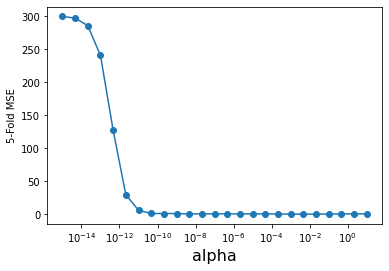

In [ ]:
from sklearn.model_selection import GridSearchCV

alpha_vector = np.logspace(-15, 1, 25)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Ridge(), scoring='neg_mean_squared_error', param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector, scores, '-o')
plt.xlabel('alpha', fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()

Miramos en detalle que está ocurriendo en los valores bajos ajustando los límites del eje *y*

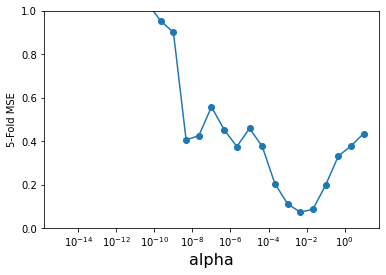

In [ ]:
plt.semilogx(alpha_vector, scores, '-o')
plt.xlabel('alpha', fontsize=16)
plt.ylabel('5-Fold MSE')
plt.ylim((0, 1))
plt.show()

Entrenamos el modelo ahora con el valor óptimo de $\alpha$ que hemos encontrado con validación cruzada.

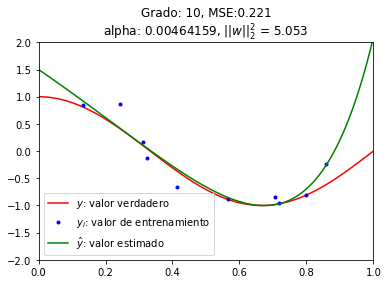

w1:  -4.224224648792869
w2:  -1.224470778992493
w3:  0.8388257771493306
w4:  1.4439115639264846
w5:  1.3230501118148013
w6:  0.9869047368945841
w7:  0.6594922919853269
w8:  0.40914806015508437
w9:  0.23984510863443598
w10:  0.13520512027055995


In [ ]:
alpha_optimo = grid.best_params_['alpha']
ridge = Ridge(alpha=alpha_optimo).fit(X_train, y_train)

# predicción
y_hat = ridge.predict(X_test)
w = ridge.coef_
norm_w2 = norm(w, 2)

# error
error_test = np.mean(np.power(y - y_hat, 2))

plt.plot(x, g_x, 'r', label='$y$: valor verdadero')
plt.plot(x_i, y_i, 'b.', label='$y_i$: valor de entrenamiento')
plt.plot(x, y_hat, 'g', label='$\hat{y}$: valor estimado')
plt.title('Grado: {:d}, MSE:{:.4g}\nalpha: {:2g}, $||w||_2^2$ = {:.4g}'.format(degree, error_test, alpha_optimo, norm_w2))
plt.legend()
plt.xlim((0, 1))
plt.ylim((-2, 2))
plt.show()

coef_names = ['w' + str(i) + ': ' for i in range(1,degree+1)]

for f,wi in zip(coef_names,w):
    print(f, wi)

### 1.2. LASSO

Se refiere al modelo de regresión lineal con penalización sobre la suma de las magnitudes de los coeficientes (norma 1):

$$\min_{\boldsymbol{\omega}}|| \mathbf{y} - \mathbf{X}\boldsymbol{\omega}||_2^2 + \alpha ||\boldsymbol{\omega} ||_1$$

donde $||\boldsymbol{\omega} ||_1 = |\omega_1| + |\omega_2| + \ldots + |\omega_D|$, siendo $D$ el número de atributos ($\omega_0$ no se tiene en cuenta en esta penalización).

Con esta formulación el algoritmo LASSO permite activar/desactivar coeficientes, de tal forma que se desactivan primero los coeficienes asociados a los atributos que menos influyen en la función de coste (función a minimizar anterior). Con ello:

1. Se previene el overfitting, al poder utilizar modelos con menos variables (las desactivamos)
2. Se gana interpretabilidad, al poder ver cómo evolucionan las variables supervivientes y poder explicar los resultados en base a menos variables.

La activación y desactivación de variables está determinada por el parámetro de regularización $\alpha$, de la misma forma que sucede en el algoritmo Ridge:

* Si $\alpha = 0$, entonces el resultado coincide con un modelo de [regresión lineal](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).
* Si $\alpha \to \infty$, entonces el valor de todos los coeficientes será nulo.

### Ejercicio
Repite los pasos anteriores realizados sobre el algoritmo *Ridge regression*, para el algoritmo <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html">LASSO</a>

### Solución

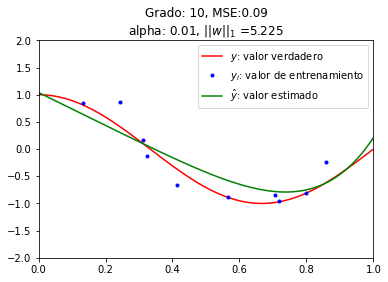

w1:  -3.028579892379494
w2:  -0.0
w3:  0.0
w4:  0.0
w5:  0.8664928808278587
w6:  1.3300948828036039
w7:  0.0
w8:  0.0
w9:  0.0
w10:  0.0


In [ ]:
from sklearn.linear_model import Lasso


alpha = 1e-2
lasso = Lasso(alpha=alpha).fit(X_train, y_train)
w = lasso.coef_
norm_w1 = norm(w, 1)

# predicción
y_hat = lasso.predict(X_test)

# error
error_test = np.mean(np.power(y - y_hat, 2))

plt.plot(x, g_x, 'r', label='$y$: valor verdadero')
plt.plot(x_i, y_i, 'b.', label='$y_i$: valor de entrenamiento')
plt.plot(x, y_hat, 'g', label='$\hat{y}$: valor estimado')
plt.title('Grado: %i, MSE:%.2f\nalpha: %g, $||w||_1$ =%.4g' % (degree, error_test, alpha, norm_w1))
plt.legend()
plt.xlim((0, 1))
plt.ylim((-2, 2))
plt.show()

coef_names = ['w' + str(i) + ': ' for i in range(1, degree+1)]

for f, wi in zip(coef_names, w):
    print(f, wi)

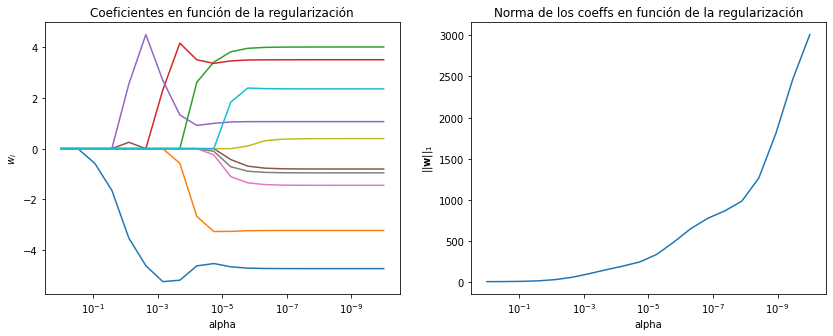

In [ ]:
n_alphas = 20
alphas = np.logspace(-10, 0, n_alphas)
coefs = []

norm1_coefs = []
for a in alphas:
    lasso = Lasso(alpha=a).fit(X_train, y_train)
    coefs.append(lasso.coef_)
    norm1_coefs.append(norm(lasso.coef_, 1))

# Display results
plt.figure(figsize=(14, 5))

ax = plt.subplot(1, 2, 1)
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('$w_i$')
plt.title('Coeficientes en función de la regularización')
plt.axis('tight')


ax = plt.subplot(1, 2, 2)
ax.plot(alphas, norm2_coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('$||\mathbf{w}||_1$')
plt.title('Norma de los coeffs en función de la regularización')
plt.axis('tight')
plt.show()

best mean cross-validation score: -0.085
best parameters: {'alpha': 0.002154434690031882}


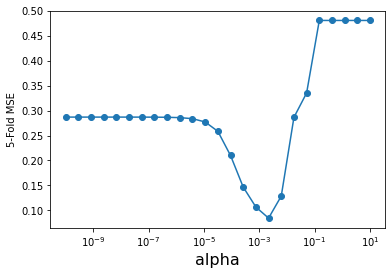

In [ ]:
alpha_vector = np.logspace(-10, 1, 25)

param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 5)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector, scores, '-o')
plt.xlabel('alpha', fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()

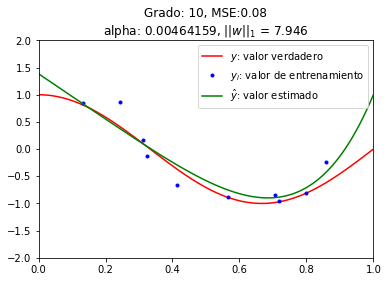

w1:  -4.165541611374085
w2:  -0.0
w3:  0.0
w4:  0.0
w5:  3.7808460991903607
w6:  0.0
w7:  0.0
w8:  0.0
w9:  0.0
w10:  0.0


In [ ]:
alpha_optimo = grid.best_params_['alpha']
lasso = Lasso(alpha=alpha_optimo).fit(X_train, y_train)

# predicción
y_hat = lasso.predict(X_test)
w = lasso.coef_
norm_w1 = norm(w, 1)

# error
error_test = np.mean(np.power(y - y_hat, 2))


plt.plot(x, g_x, 'r', label='$y$: valor verdadero')
plt.plot(x_i, y_i, 'b.', label='$y_i$: valor de entrenamiento')
plt.plot(x, y_hat, 'g', label='$\hat{y}$: valor estimado')
plt.title('Grado: %i, MSE:%.2f\nalpha: %g, $||w||_1$ = %.4g' % (degree, error_test, alpha_optimo, norm_w1))
plt.legend()
plt.xlim((0, 1))
plt.ylim((-2, 2))
plt.show()

coef_names = ['w' + str(i) + ': ' for i in range(1, degree+1)]

for f, wi in zip(coef_names, w):
    print(f, wi)

### Ejercicio
A la vista de los resultados, ¿qué diferencias entre Ridge y LASSO destacarías?

### Solución

LASSO da preferencia a soluciones más dispersas (*sparse*, con pocos elementos no nulos)

## 2. Regularización sobre algoritmos de clasificación

### 2.1. Regresión logística

Algunos algoritmos de clasificación también tienen un parámetro que permite controlar su complejidad. En el caso de [regresión logística](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression), la función de coste a minimizar es de la forma:

$$J(\boldsymbol{\omega}) = \sum_{i=1}^N \log{\left(1+ e^{-y^{(i)}\boldsymbol{\omega}^T\mathbf{x}^{(i)}}\right)}$$

donde $y^{(i)} \in \{-1, 1\}$. En su versión "regularizada", la función de coste pasa a ser:

$$J(\boldsymbol{\omega}) = \frac{1}{2}||\boldsymbol{\omega}||_2^2 + C \sum_{i=1}^N \log{\left(1+ e^{-y^{(i)}\boldsymbol{\omega}^T\mathbf{x}^{(i)}}\right)}$$

El **coste $C$** es el parámetro libre que permite controlar la complejidad del algoritmo, penalizando los errores que se comenten en clasificación. Este parámetro supone un compromiso entre la exactitud de la solución y la complejidad del algoritmo, en ese sentido es similar al parámetro de regularización $\alpha$ que utilizamos en Ridge y Lasso. En este caso, de forma intuitiva podemos decir que **$C$ se comporta como  $1/\alpha$**. Así:

- Cuanto mayor es $C$ (menor es $\alpha$), más penalizamos los errores en clasificación y la frontera se ajusta mucho a los datos (en el caso extremo se ajustará perfectamente). Riesgo de overfitting pero con potencial menor error de clasificación.


- Cuanto menor es $C$ (mayor es $\alpha$), menos penalizamos los errores en clasificación y tenderemos hacia modelos más sencillos (fronteras menos ajustadas, menor riesgo de overfitting pero potencialmente con más error de clasificación)

NOTA: por defecto, $C=1$ en `scikit-learn`.

Veamos cómo funciona $C$ sobre unos ejemplos de clasificación. Primero, cargamos/construimos los datos de los ejemplos:

In [ ]:
# ejemplo 1
ejemplo1 = pd.read_csv("./data/ex2data1.txt", sep=",", header=None, names=['x1', 'x2','label'])

# ejemplo 2
ejemplo2 = pd.read_csv("./data/ex2data2.txt", sep=",", header=None, names=['x1', 'x2','label'])

# ejemplo 3: Problema XOR
np.random.seed(0)

# -- parameters
N     = 800
mu    = 1.5      # Cambia este valor
sigma = 1      # Cambia este valor

# variables auxiliares
unos = np.ones(int(N/4))
random4 = sigma*np.random.randn(int(N/4),1)
random2 = sigma*np.random.randn(int(N/2),1)

# -- features
y3 = np.concatenate([-1*unos,       unos,          unos,         -1*unos])
X1 = np.concatenate([-mu + random4, mu + random4, -mu + random4, mu + random4])
X2 = np.concatenate([+mu + random2,               -mu + random2])
X3 = np.hstack((X1,X2))

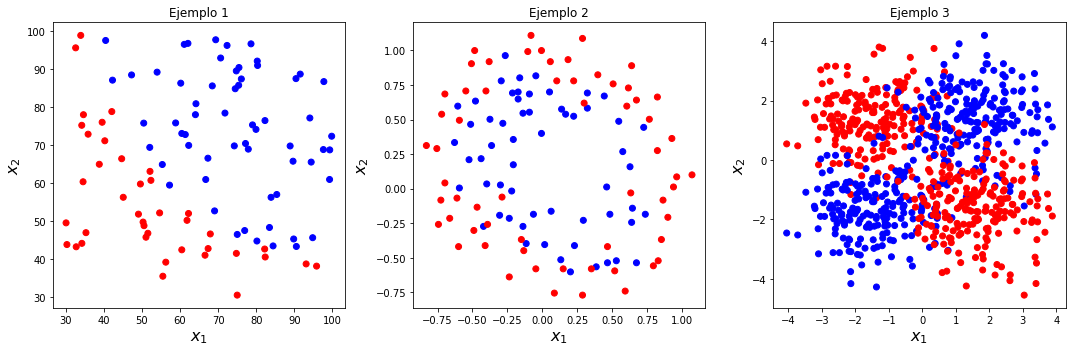

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.scatter(ejemplo1['x1'], ejemplo1['x2'], c=ejemplo1['label'], cmap=cm_bright)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)
plt.title('Ejemplo 1')

plt.subplot(1,3,2)
plt.scatter(ejemplo2['x1'], ejemplo2['x2'], c=ejemplo2['label'], cmap=cm_bright)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)
plt.title('Ejemplo 2')

plt.subplot(1,3,3)
plt.scatter(X3[:,0], X3[:,1], c=y3, cmap=cm_bright)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)
plt.title('Ejemplo 3')

plt.tight_layout()
plt.show()

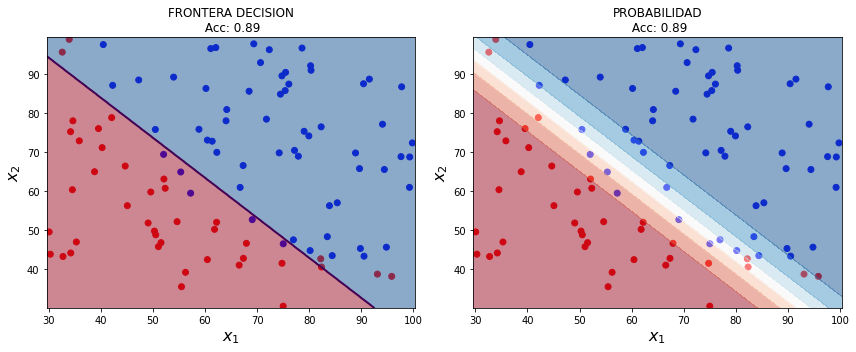

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# preparamos los datos
data1 = ejemplo1.values
X1 = data1[:,0:2]
y1 = data1[:,-1]

# creamos el modelo
lr1 = LogisticRegression()

# ajustamos con los datos disponibles
lr1.fit(X1, y1)
plot_decision_boundary(X1, y1, 0.05, lr1)

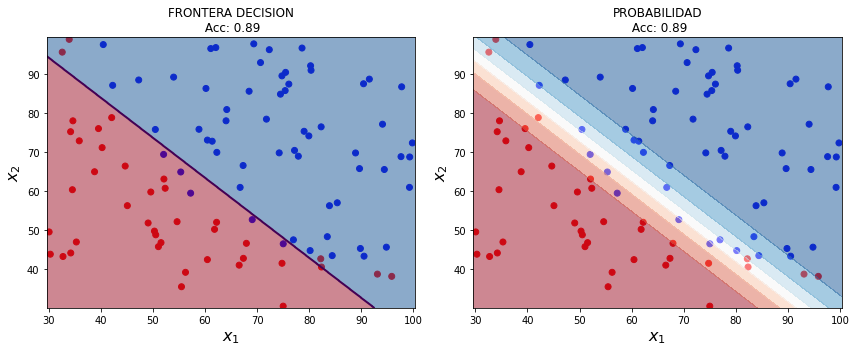

In [ ]:
# C grande (ANTES DE EJECUTAR, TRATA DE PENSAR CÓMO SERÁ EL RESULTADO!)
lrcgrande = LogisticRegression(C=9000000000000000000000)
lrcgrande.fit(X1, y1)
plot_decision_boundary(X1, y1, 0.05, lrcgrande)

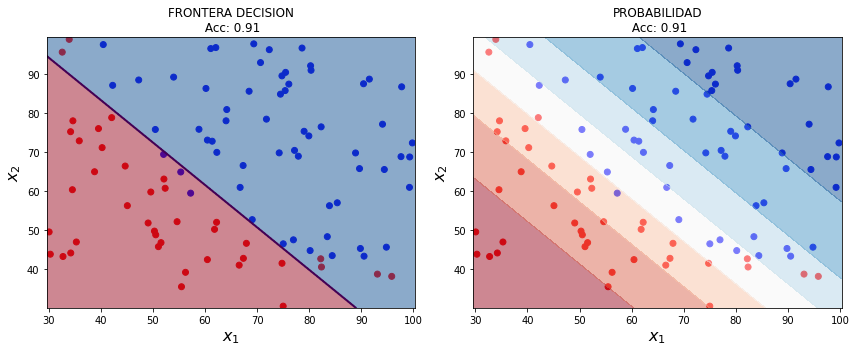

In [ ]:
# C pequeño (ANTES DE EJECUTAR TRATA DE PENSAR CÓMO SERÁ EL RESULTADO!)
lrcpequena = LogisticRegression(C=0.0004)
lrcpequena.fit(X1, y1)
plot_decision_boundary(X1, y1, 0.05, lrcpequena)

### Ejercicio
Aplica el algoritmo de regresión logística sobre los ejemplos 2 y 3 anteriores, variando el valor de $C$.

### Solución

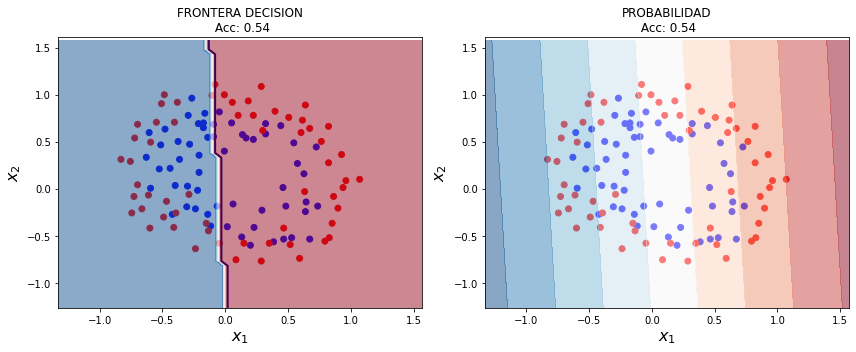

In [ ]:
# Ejemplo 2
data2 = ejemplo2.values
X2 = data2[:,0:2]
y2 = data2[:,-1]

# creamos el modelo
lr2 = LogisticRegression()

# ajustamos con los datos disponibles
lr2.fit(X2, y2)
plot_decision_boundary(X2, y2, 0.05, lr2)

(118, 6)


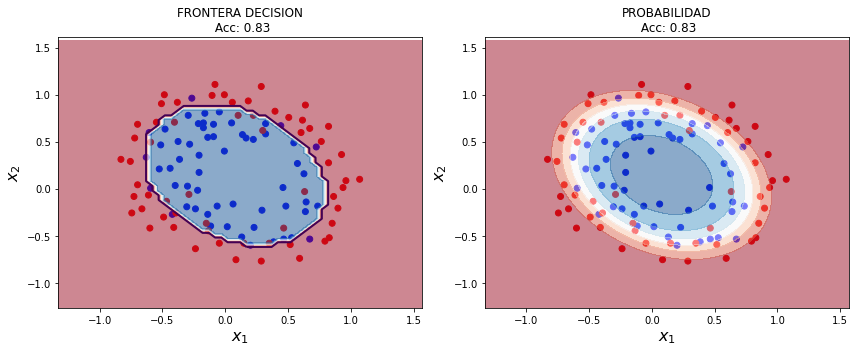

In [ ]:
poly = PolynomialFeatures(2)
X2poly = poly.fit_transform(X2)
print(X2poly.shape)

lr2_poly = LogisticRegression(C=10, fit_intercept=False).fit(X2poly, y2)
plot_decision_boundary_poly(X2, y2, 0.05, lr2_poly, poly)

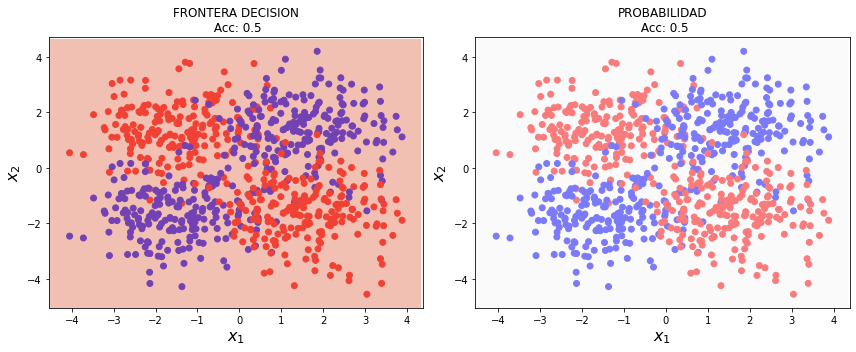

In [ ]:
# Ejemplo 3
lr3 = LogisticRegression().fit(X3, y3)
plot_decision_boundary(X3, y3, 0.05, lr3)

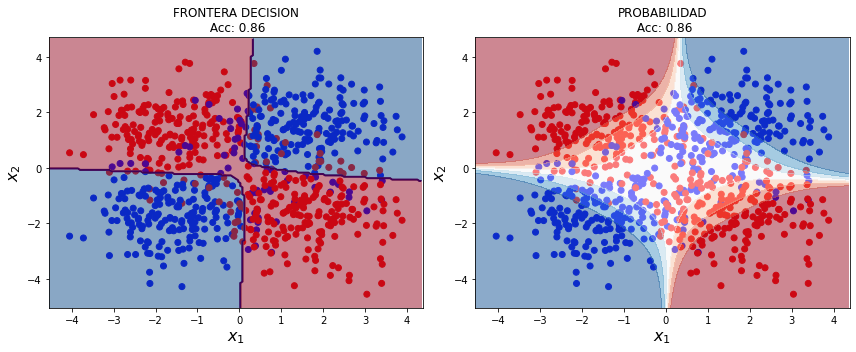

In [ ]:
poly = PolynomialFeatures(4)
X3poly = poly.fit_transform(X3)

lr3_poly = LogisticRegression(C=0.001, fit_intercept=False).fit(X3poly, y3)
plot_decision_boundary_poly(X3, y3, 0.05, lr3_poly, poly)

Pero cuidado, no hagamos trampas, ¿cómo tenemos que seleccionar el valor de $C$ adecuado para el problema?

### Ejercicio
Calcula el valor óptimo de $C$ para el ejemplo 3.

### Solución

best mean cross-validation score: 0.871
best parameters: {'C': 0.00020691380811147902}
test-set score: 0.86


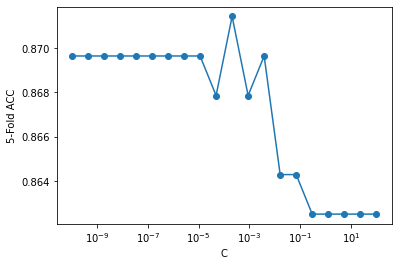

In [ ]:
from sklearn.model_selection import train_test_split

poly     = PolynomialFeatures(2)
X3poly   = poly.fit_transform(X3)
X_train, X_test, y_train, y_test = train_test_split(X3poly, y3, test_size=0.3, shuffle=True, random_state=0)

vectorC = np.logspace(-10, 2, 20)
param_grid = {'C': vectorC}
grid = GridSearchCV(LogisticRegression(fit_intercept=False), scoring='accuracy', param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.2f}".format(grid.score(X_test, y_test)))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(vectorC, scores, '-o')
plt.xlabel('C')
plt.ylabel('5-Fold ACC')
plt.show()

### Ejercicio
Representa la frontera de separación para el valor de $C$ óptimo.

### Solución

MSE train: 0.5214285714285715
MSE test: 0.55


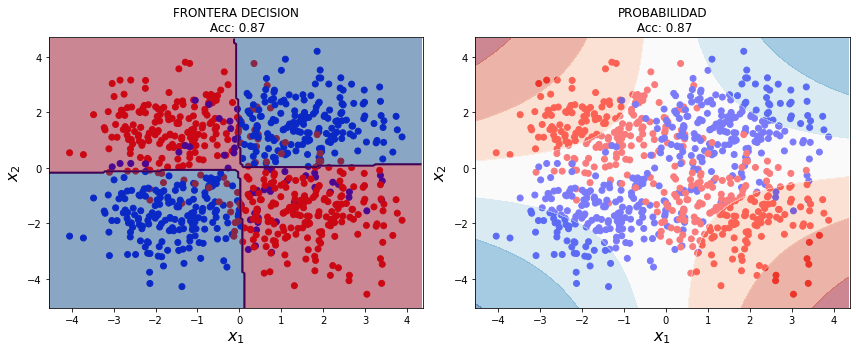

In [ ]:
Copt = grid.best_params_['C']
lr3_poly = LogisticRegression(C=Copt, fit_intercept=False).fit(X_train, y_train)
y_pred_train = lr3_poly.predict(X_train)
y_pred_test = lr3_poly.predict(X_test)

mse_train = np.mean((y_train-y_pred_train)**2)
mse_test = np.mean((y_test-y_pred_test)**2)

print('MSE train:', mse_train)
print('MSE test:', mse_test)

plot_decision_boundary_poly(X3, y3, 0.05, lr3_poly, poly)

A pesar de que la búsqueda de parámetros libres nos proporcione un valor óptimo, quizá éste está demasiado ajustado, por lo tanto es recomendable representar el resultado, en la medida de lo posible, e interpretarlo de forma correcta.

Casi todos los algoritmos de machine learning tienen un parámetro que controla la complejidad del mismo, y tenemos que conocer cómo afecta al resultado. Eso sí, para calcular su valor, siempre utilizaremos una estrategia adecuada de selección del modelo (normalmente validación cruzada). Y nunca, nunca, utilizaremos el conjunto de test.